<a href="https://colab.research.google.com/github/akshayanant/nlp-google-colab/blob/main/obj_det_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 8.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=6c912b878b0e6c4efcd323963b92213efa17faac6dedbb9493cc373d0f2071fd
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 1.8MB/s 
     |████████████████████████████████| 2.2MB 9.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201111-cp36-none-any.whl size=44418 sha256=0cd81e7edbe680ed1d8692a0287f0f1782a37de69e2da579329bf352fb8f00af
  Stored in directory: /root/.cache/pip/wheels/70/d9/52/49a17f0d21e723c371c4a3f60138545e0a4163c5f7ff42c855
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import pandas as pd
import numpy as np
from os import walk
import progressbar
import json



In [ ]:
!unzip './data/KK_Images.zip'

Archive:  ./data/KK_Images.zip
   creating: full_images/
  inflating: full_images/2_full_image.jpg  
  inflating: full_images/1_full_image.jpg  
  inflating: full_images/10_full_image.jpg  
  inflating: full_images/4_full_image.jpg  
  inflating: full_images/5_full_image.jpg  
  inflating: full_images/6_full_image.jpg  
  inflating: full_images/7_full_image.jpg  
  inflating: full_images/12_full_image.jpg  
  inflating: full_images/13_full_image.jpg  
  inflating: full_images/14_full_image.jpg  
  inflating: full_images/16_full_image.jpg  
  inflating: full_images/17_full_image.jpg  
  inflating: full_images/20_full_image.jpg  
  inflating: full_images/22_full_image.jpg  
  inflating: full_images/23_full_image.jpg  
  inflating: full_images/25_full_image.jpg  
  inflating: full_images/27_full_image.jpg  
  inflating: full_images/28_full_image.jpg  
  inflating: full_images/29_full_image.jpg  
  inflating: full_images/30_full_image.jpg  
  inflating: full_images/31_full_image.jpg  
  in

In [ ]:
data_frame = pd.read_csv('./bounding_boxes.csv')

In [ ]:
DatasetCatalog.remove('full_image_train')

In [ ]:
from detectron2.structures import BoxMode

def get_image_dicts():

    dataset_dicts = []
    for idx, row in enumerate(data_frame.iterrows()):
        record = {}
        
        
        
        record["file_name"] = './full_images/' + str(row[1][0])
        record["image_id"] = idx
        record["height"] = 576
        record["width"] = 1024
      
        objs = []
        h = row

        obj = {
            "bbox": [int(row[1][1]),int(row[1][4]),int(row[1][3]),int(row[1][2])],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


DatasetCatalog.register("full_image_train", get_image_dicts)
MetadataCatalog.get("full_image_train").set(thing_classes=["seg_image"])
full_image_metadata = MetadataCatalog.get("full_image_train")

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("full_image_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR 0.00025 
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/19 01:40:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 58.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[11/19 01:40:11 d2.engine.train_loop]: Starting training from iteration 0
[11/19 01:40:22 d2.utils.events]:  eta: 0:08:36  iter: 19  total_loss: 0.7347  loss_cls: 0.5725  loss_box_reg: 0.1323  loss_rpn_cls: 0.005335  loss_rpn_loc: 0.002616  time: 0.5339  data_time: 0.0153  lr: 4.9953e-06  max_mem: 2767M
[11/19 01:40:33 d2.utils.events]:  eta: 0:09:03  iter: 39  total_loss: 0.6824  loss_cls: 0.5149  loss_box_reg: 0.1409  loss_rpn_cls: 0.001171  loss_rpn_loc: 0.002655  time: 0.5506  data_time: 0.0058  lr: 9.9902e-06  max_mem: 2767M
[11/19 01:40:44 d2.utils.events]:  eta: 0:08:43  iter: 59  total_loss: 0.5434  loss_cls: 0.3809  loss_box_reg: 0.1316  loss_rpn_cls: 0.008133  loss_rpn_loc: 0.002048  time: 0.5423  data_time: 0.0048  lr: 1.4985e-05  max_mem: 2767M
[11/19 01:40:54 d2.utils.events]:  eta: 0:08:19  iter: 79  total_loss: 0.4244  loss_cls: 0.256  loss_box_reg: 0.1369  loss_rpn_cls: 0.00519  loss_rpn_loc: 0.003618  time: 0.5378  data_time: 0.0047  lr: 1.998e-05  max_mem: 2767M
[11/1

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
cfg = get_cfg()
cfg.MODEL.WEIGHTS = os.path.join('models', "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

predictor = DefaultPredictor(cfg)

Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

In [ ]:
def infer(img_file,grayscale = False) :

    img = cv2.imread(img_file)
    if grayscale : 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        img = img2
    pred = predictor(img)
    print(pred)
    v = Visualizer(img,metadata=full_image_metadata)
    out = v.draw_instance_predictions(pred["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
def infer_img(img_file,grayscale = False) :
    
    img = cv2.imread(img_file)
    if grayscale : 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        img = img2
    pred = predictor(img)
    return pred['instances'].pred_boxes

In [ ]:
file_names = []

for (dirpath, dirnames, filenames) in walk('./full_images'):
    file_names.extend(filenames)

img_files = list(map(lambda x : './full_images/' + x , file_names))



In [ ]:
print(filename)
print(records[0]['file_name'])

110_full_image.jpg
./full_images/2_full_image.jpg


In [ ]:
row = data_frame[(data_frame.iloc[:,0] == filename)]

In [ ]:
print(row)

Empty DataFrame
Columns: [1_full_image.jpg, 579, 353, 643, 279]
Index: []


In [ ]:
row.iloc[0,0]

IndexError: ignored

In [ ]:
def get_closest_match(boxes, gt) :
 
    min = float('inf')
    res = -1
    for idx,box in enumerate(boxes) : 
        box = box['bbox']
        dist = (box[0]-gt[0])**2 + (box[1]-gt[1])**2 + (box[2]-gt[2])**2 + (box[3]-gt[3])**2
        if(min>dist):
            min = dist
            res = idx
    return res
 

In [ ]:
images = []

for record in progressbar.progressbar(records) : 
    pred_boxes = infer_img(record['file_name'])
    anns = []
    for idx, box in enumerate(pred_boxes) : 
        vals = []
        for x in box : 
            vals.append(x.item())

        ann = {
            'id' : idx,
            'bbox': vals
        }
        anns.append(ann)
    filename = record['file_name'].split('/')[-1]
    row = data_frame[(data_frame.iloc[:,0]==filename)]
    gt = [row.iloc[0][1],row.iloc[0][4],row.iloc[0][3],row.iloc[0][2]]
    gt= get_closest_match(anns,gt)
    img = {
	    'file_name' : record['file_name'],
	    'image_id'  : record['image_id'],
	    'height'    : record['height'],
	    'width'     : record['width'], 
	    'annotations' : anns,
	    'ground_truth' : gt
    }

    images.append(img)
  



100% (2000 of 2000) |####################| Elapsed Time: 0:04:41 Time:  0:04:41


In [ ]:
res = {'images' : images}

In [ ]:
with open('./results.json','w') as f : 
    json.dump(res,f)

In [ ]:
print(res)

{'images': [{'file_name': './full_images/2_full_image.jpg', 'image_id': 0, 'height': 576, 'width': 1024, 'annotations': [{'id': 0, 'bbox': [248.131591796875, 275.0060729980469, 290.39276123046875, 316.1223449707031]}, {'id': 1, 'bbox': [383.8823547363281, 364.4626770019531, 460.4601135253906, 455.1062927246094]}, {'id': 2, 'bbox': [555.3067626953125, 258.7373352050781, 587.3602905273438, 351.03363037109375]}, {'id': 3, 'bbox': [790.4719848632812, 295.6363525390625, 833.86376953125, 335.7506103515625]}], 'ground_truth': 1}, {'file_name': './full_images/3_full_image.jpg', 'image_id': 1, 'height': 576, 'width': 1024, 'annotations': [{'id': 0, 'bbox': [376.1184387207031, 289.3160095214844, 443.482666015625, 354.767578125]}, {'id': 1, 'bbox': [611.1943969726562, 333.9782409667969, 650.1622314453125, 419.9977111816406]}, {'id': 2, 'bbox': [168.3690643310547, 366.3367614746094, 217.4410858154297, 413.1159362792969]}, {'id': 3, 'bbox': [718.08740234375, 258.5321044921875, 856.7003173828125, 33

In [ ]:
print(images[1])

{'file_name': './full_images/3_full_image.jpg', 'image_id': 1, 'height': 576, 'width': 1024, 'annotations': [{'id': 0, 'bbox': [376.1184387207031, 289.3160095214844, 443.482666015625, 354.767578125]}, {'id': 1, 'bbox': [611.1943969726562, 333.9782409667969, 650.1622314453125, 419.9977111816406]}, {'id': 2, 'bbox': [168.3690643310547, 366.3367614746094, 217.4410858154297, 413.1159362792969]}, {'id': 3, 'bbox': [718.08740234375, 258.5321044921875, 856.7003173828125, 337.3677062988281]}], 'ground_truth': 3}


{'instances': Instances(num_instances=4, image_height=576, image_width=1024, fields=[pred_boxes: Boxes(tensor([[428.4487, 335.7527, 498.6921, 413.9859],
        [742.5182, 289.9007, 838.7596, 438.7799],
        [578.9803, 278.5105, 643.3856, 353.3675],
        [202.1749, 256.2934, 274.3024, 399.6288]], device='cuda:0')), scores: tensor([0.7097, 0.5659, 0.4774, 0.4559], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}


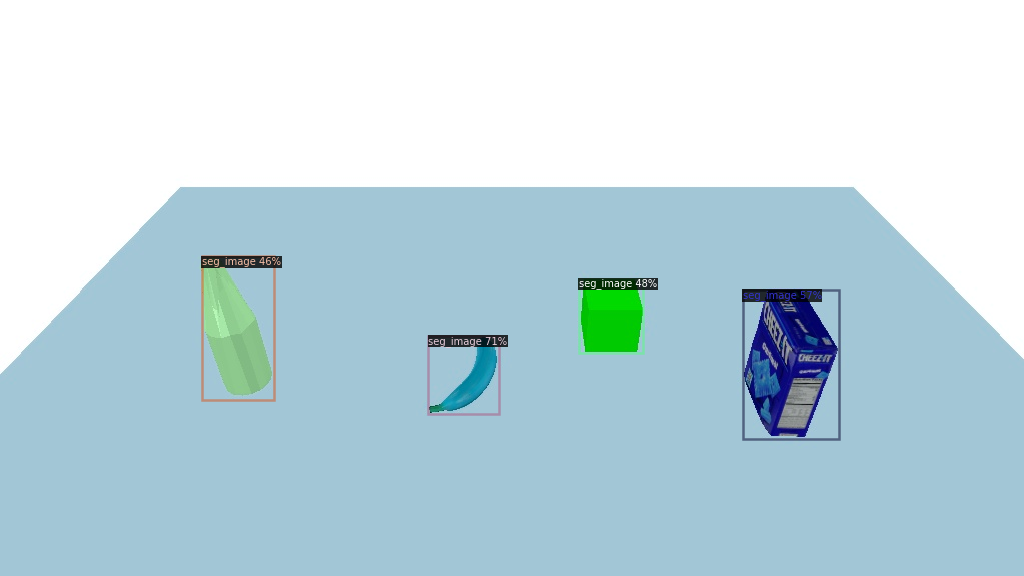

In [ ]:
infer('./full_images/1_full_image.jpg')